# Quora Question Pairs Similarity prediction

### 1. Busines Problem

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Credits: Kaggle 

### 2. Problem Statement 
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

- Source : https://www.kaggle.com/c/quora-question-pairs

### 3. Useful Links
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

### 4. Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

### 5. Machine Learning Probelm 

**5.1 Data Overview:**
- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290

**5.2 Sample Data points:**

"id","qid1","qid2","question1","question2","is_duplicate"

"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"

"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"

"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"

"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"

**5.3 Mapping real world problem to a Machine Learning Problem:**

* Type of ML problem: It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

* Performance metric to choose: (Source: https://www.kaggle.com/c/quora-question-pairs#evaluation)
    - Log-loss 
    - Binary Confusion Matrix

**5.4 Train and Test data construction**

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

# 0.Importing necessary libraries 

In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

! pip install distance 
! pip install fuzzywuzzy
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS

from collections import Counter
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

     |████████████████████████████████| 184kB 2.7MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=7835dfcfe3b312ddb89a9e95c2958c20d6903f5c493476dc61b8a610c6be261a
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [0]:
# mount google drive 

from google.colab import drive 

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1. Loading and exploring data

In [0]:
# reading data from google drive

my_path = '/content/gdrive/My Drive/Applied AI Case Studies/CS1_Quora_Question_Pair/'
df = pd.read_csv(my_path + 'train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
# shape of dataframe

df.shape

(404290, 6)

In [0]:
# all columns in the data 

df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [0]:
# high-level information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
# check if any null values are present

df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [0]:
# check the for samples with null-value entries in 'question2' column

df[df['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [0]:
# check the samples with null-value entries in 'question1' column

df[df['question1'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [0]:
# replace the null values with ' '

df = df.fillna('')
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

0    255027
1    149263
Name: is_duplicate, dtype: int64


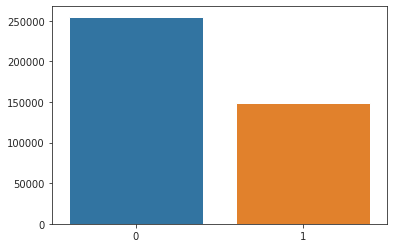

In [0]:
# plotting the bar plot of the class-label distribution

print(df.is_duplicate.value_counts())

sns.set_style("ticks")
label_data = df.is_duplicate.value_counts().to_dict()
sns.barplot(list(label_data.keys()), list(label_data.values()))
plt.show()

In [0]:
# percentage of the respective class labels 

print("Percentage of dissimilar question pairs i.e. is_duplicate = 0 : {} %".format(
      round(label_data[0]*100/sum(label_data.values()),2)))

print("Percentage of similar question pairs i.e. is_duplicate = 1 : {} %".format(
      round(label_data[1]*100/sum(label_data.values()),2)))

Percentage of dissimilar question pairs i.e. is_duplicate = 0 : 63.08 %
Percentage of similar question pairs i.e. is_duplicate = 1 : 36.92 %


In [0]:
df_dup = df[df['is_duplicate'] == 1]
df_nondup = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
dup = np.dstack([df_dup["question1"], df_dup["question2"]]).flatten()
nondup = np.dstack([df_nondup["question1"], df_nondup["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :", len(dup))
print ("Number of data points in class 0 (non duplicate pairs) :", len(nondup))

#Saving the np array into a text file
np.savetxt('train_p.txt', dup, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', nondup, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("nor")
stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :", len(textp_w))
print ("Total number of words in non duplicate pair questions :", len(textn_w))

Total number of words in duplicate pair questions : 16087608
Total number of words in non duplicate pair questions : 33092279


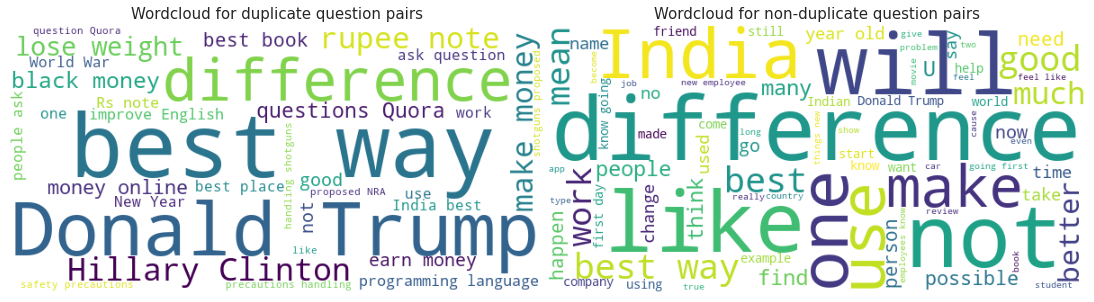

In [0]:
# plot the WordCloud images

wordcloud_dup = WordCloud(width = 600, height = 300, background_color ='white', 
                      stopwords = stopwords, min_font_size = 10).generate(textp_w)

wordcloud_nondup = WordCloud(width = 600, height = 300, background_color ='white', 
                      stopwords = stopwords, min_font_size = 10).generate(textn_w)

plt.figure(figsize = (15, 8), facecolor = None) 
plt.subplot(1,2,1)
plt.imshow(wordcloud_dup) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Wordcloud for duplicate question pairs", fontsize = 15) 

plt.subplot(1,2,2)
plt.imshow(wordcloud_nondup) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Wordcloud for non-duplicate question pairs", fontsize = 15)

plt.show() 

In [0]:
# finding number of duplicate entries in the data by qids

df[df[['qid1', 'qid2']].duplicated() == True]

,id,qid1,qid2,question1,question2,is_duplicate


In [0]:
# finding number of duplicate entries in the data by questions

df[df[['question1', 'question2']].duplicated() == True]

,id,qid1,qid2,question1,question2,is_duplicate


Thus there are no duplicate entries in the dataset.

Number of unique questions =  537933


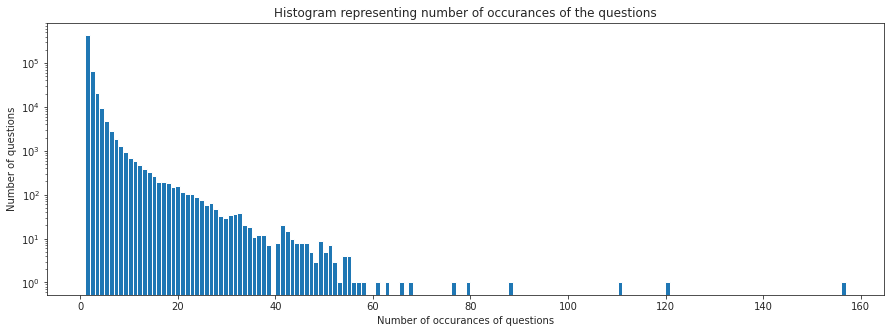

Max number of times a single question is repeated =  157


In [0]:
# determining number of unique questions in the dataset and plotting histogram

qids = pd.Series(list(df['qid1']) + list(df['qid2']))
print("Number of unique questions = ", len(set(qids)))  # can also use len(np.unique(qids))

sns.set_style('ticks')
plt.figure(figsize = (15, 5))
plt.hist(qids.value_counts(), bins = 160)
plt.yscale('log')
plt.title("Histogram representing number of occurances of the questions")
plt.xlabel("Number of occurances of questions")
plt.ylabel("Number of questions")
plt.show()

print("Max number of times a single question is repeated = ", max(qids.value_counts()))

OBSERVATIONS 
* Majority of the questions are asked just once. 
* Very few questions that are asked beyond 10 times.
* 1 particular question is asked 157 times and that's the highest!

# 2. Basic Feature Extraction 

Let us now construct some few features like:
 - __freq_qid1__  =  Frequency of qid1's

 - __freq_qid2__  =  Frequency of qid2's 

 - __q1len__  =  Length of q1

 - __q2len__  =  Length of q2

 - __q1_n_words__ =  Number of words in Question 1

 - __q2_n_words__  =  Number of words in Question 2

 - __word_common__  =  Number of common unique words in Question 1 and Question 2

 - __word_total__  = Total of non-repetative words in Question 1 and Question 2

 - __word_share__  =  (word_common)/(word_Total)

 - __freq_q1+freq_q2__  =  sum total of frequency of qid1 and qid2 

 - __freq_q1-freq_q2__  =  absolute difference of frequency of qid1 and qid2 

In [0]:
# before extracting the features based on the words first we need to decontract the english phrases within the questions 
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    
    #general 
    phrase = re.sub(r"n\'t", " not",   phrase)
    phrase = re.sub(r"\'re", " are",   phrase)
    phrase = re.sub(r"\'s",  " is",    phrase) 
    phrase = re.sub(r"\'d",  " would", phrase)
    phrase = re.sub(r"\'ll", " will",  phrase)
    phrase = re.sub(r"\'t",  " not",   phrase)
    phrase = re.sub(r"\'ve", " have",  phrase)
    phrase = re.sub(r"\'m",  " am",    phrase)
    phrase = re.sub(r"\'em", " them",  phrase)
    return phrase

In [0]:
# decontract all questions in 'question 1' and 'question 2' columns

q1_list = []
for q1 in df['question1'].values:
    q1_list.append(decontracted(q1))

df['clean_question1'] =  q1_list

q2_list = []
for q2 in df['question2'].values:
    q2_list.append(decontracted(q2))

df['clean_question2'] =  q2_list

In [0]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,clean_question1,clean_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...


In [0]:
# here we are grouping based on column 'qid1'. 
# so that all same questions in 'qid1' gets sorted then we are performing count. 
# so we get counting of repeated questions.if we don't use ['qid1'] then this count is copied on to 5 rows -
# (i.e id,qid2, question1, question2, is_duplicate) and returns us 5 column dataframe.

In [0]:
#  Frequency of qid1's
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 

#  Frequency of qid2's
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

# Length of question1
df['q1len'] = df['clean_question1'].str.len() 

# Length of question2
df['q2len'] = df['clean_question2'].str.len()

# Number of words in question 1
df['q1_n_words'] = df['clean_question1'].apply(lambda x: len(x.strip().split()))

# Number of words in question 2
df['q2_n_words'] = df['clean_question2'].apply(lambda x: len(x.strip().split()))

In [0]:
# number of unique words that are common in 'question1' and 'question2' columns
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['clean_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['clean_question2'].split(" ")))    
    return 1.0 * len(w1 & w2)  # set operation
df['word_common'] = df.apply(normalized_word_common, axis=1)

# total number of words in 'question1' and 'question2' columns
def normalized_word_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['clean_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['clean_question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2)) # set operation 
df['word_total'] = df.apply(normalized_word_total, axis=1)

# word_share = (word_common)/(word_total)
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['clean_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['clean_question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

# sum of frequencies
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']

# absolute value of difference of frequencies 
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,clean_question1,clean_question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


#  3. Analysis of the Extracted features 

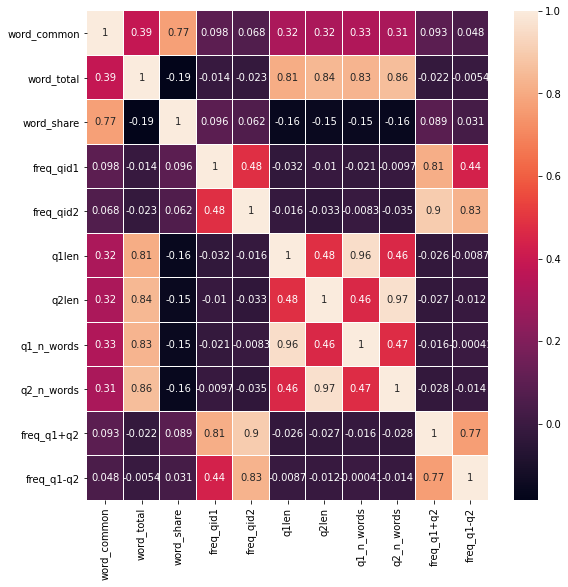

In [0]:
# determining the correlation among the newly formed features 

corr_df = df[['word_common', 'word_total', 'word_share', 'freq_qid1','freq_qid2', 
            'q1len','q2len', 'q1_n_words', 'q2_n_words', 'freq_q1+q2','freq_q1-q2']]

plt.figure(figsize = (9,9))
corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix, linewidth = 0.01, annot = True)
plt.show()

OBSERVATION

As expected, 
* There is a good correlation between 'word_share' and 'word_common'.

* There is high correlation between total number of unique words in question1 & question2 and number of words in question1, number of words in question2, string length of question1, string length of question2.

* There is very high correlation between the length of string of question and the number of words in the respective questions.

* There is also high correlation between individual question1 and question2 frequencies with their sum of frequencies.


In [0]:
# some general analysis 

print("Minimum length of the questions in question1 : ", min(df['q1_n_words']))

print("Minimum length of the questions in question2 : ", min(df['q2_n_words']))

print("Number of Questions length of question1 = 1 :", df[df['q1_n_words'] == 1].shape[0])

print("Number of Questions length of question2 = 1 :", df[df['q2_n_words'] == 1].shape[0])

Minimum length of the questions in question1 :  0
Minimum length of the questions in question2 :  0
Number of Questions length of question1 = 1 : 67
Number of Questions length of question2 = 1 : 25


In [0]:
# datapoints consisting of questions with no. of words in question1 = 1

df[df['q1_n_words'] == 1][['question1','question2','word_total']].head()

,question1,question2,word_total
3306,.,Why is Cornell's endowment the lowest in the I...,10.0
13016,?,Why should one not work at Google?,8.0
17682,deleted,Which website will be suitable for downloading...,11.0
20794,?,What is the Gmail tech support help phone number?,10.0
23305,deleted,Which are some best websites for downloading n...,11.0


In [0]:
# datapoints consisting of questions with no. of words in question2 = 1

df[df['q2_n_words'] == 1][['question1','question2','word_total']].head()

,question1,question2,word_total
20072,How could I solve this?,…………..,6.0
46596,How To Edit DNA?,What?,5.0
47056,Is there anywhere in the world offering pain m...,?,19.0
51909,What should yellow taxis do to face competitio...,What?,13.0
74304,Is there any chances for hailstones tomorrow?,parisflatlist,8.0


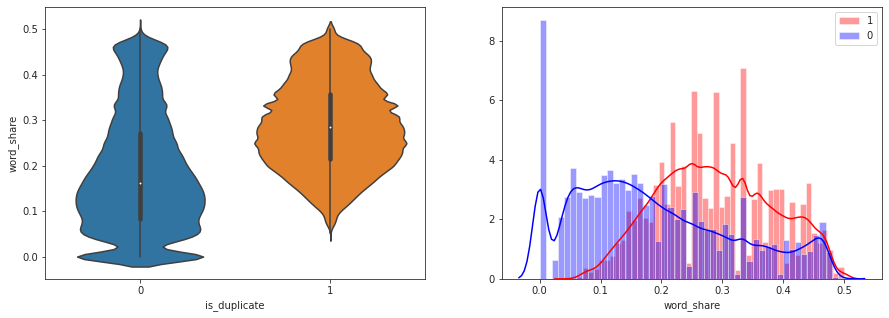

In [0]:
# violin plot and PDF of the feature "word_share"

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:], label = "1",  color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:], label = "0",  color = 'blue')
plt.legend()
plt.show()

This feature can prove good in diffeentiating between the class labels as the amount of overlap is not very high.

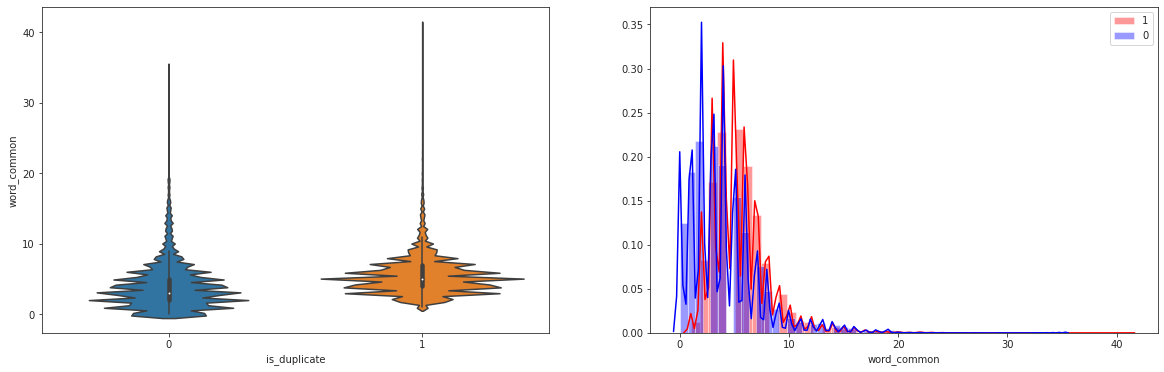

In [0]:
# violin plot and PDF of the feature "word_common"

plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:], label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:], label = "0", color = 'blue' )
plt.legend()
plt.show()

This feature individually cannot prove good in diffeentiating between the class labels as the amount of overlap is very high.

# 4. Text Preprocessing 

In [0]:
# check some random samples of question text to get an idea what preprocessing steps needs to be done

for i in range(20245,20256):
    print(df['clean_question1'][i])
    print(df['clean_question2'][i])
    print(df['is_duplicate'][i])
    print(" ")

What are the foods that I should avoid to lose weight?
What is the single most effective food item to avoid eating in order to help lose weight?
0
 
How do we stop social media addiction?
How do I overcome my social media addiction?
1
 
How can hydrogen peroxide remove stains?
How can carpet stains be removed with hydrogen peroxide?
0
 
Is Hinduism a religion?
Is Hinduism a religion or a way of life?
1
 
Would you describe yourself as weird?
What if ISIS is with America?
0
 
How can a person become mentally mature?
How do I become a mentally mature person?
1
 
Why I feel the world is made for white people?
Would anyone brief "Microsoft Connect(); // 2016 Event"?
0
 
When sending mail, is Hong Kong the city or the country in the address block?
What are the aims of the City University of Hong Kong?
0
 
I am really embarrassed about my childhood memories of a cartoon character that I actually blocked it out from memory. How do I learn to accept this?
If you could break the RSA algorithm, 

### Text Preprocessing steps:
* Expanding contractions
* Removing html tags
* Removing symbols like '%','&', '@' etc.
* Removing Stopwords
* Performing stemming


In [0]:
# demonstration why this replacemnet is wrong 

'''
x = "7,000,000,784"
x = x.replace(",000,000", "m")
print(x)
'''


7m,784


In [0]:
# Text pre-processing pipleline - text decontractions, removing special chars, stemming

import nltk
nltk.download('punkt') # for porter-stemmer

def preprocess(sent):
    # decontraction
    sent = str(sent).lower()
    sent = sent.replace("’", "'").replace("he's", "he is").replace("she's", "she is")\
               .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
               .replace("€", " euro ")

    sent = re.sub(r"([1-9]+),000,000", r"\1m", sent) if len(sent) == 9 else sent
    sent = re.sub(r"([1-9]+),000", r"\1k", sent) if len(sent) == 5 else sent
    sent = re.sub(r"([1-9]+)000000", r"\1m", sent) if len(sent) == 7 else sent
    sent = re.sub(r"([1-9]+)000", r"\1k", sent) if len(sent) == 4 else sent 
    
    # remove other special characters
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    
    # stemming using porter stemmer
    token_words = word_tokenize(sent)
    stem_sentence = []
    for word in token_words:
        porter = PorterStemmer()
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    
    return "".join(stem_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


> Note: These stopwords consist of the words like no, nor, not which we might need to remove from the above collection of the stopwords 

In [0]:
# list of all the stopwords (except 'no', 'nor' and 'not') 
# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'br'] # 'br' added to handle line-breaks 

# 5. Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : Stop words as per NLTK.
- __Word__ : A token that is not a stop_word ( tokens minus stop words)


Features:
- __cwc_min__ :  Ratio of common_word_count to min length of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
- __cwc_max__ :  Ratio of common_word_count to max length of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
- __csc_min__ :  Ratio of common_stop_count to min length of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
- __csc_max__ :  Ratio of common_stop_count to max length of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
- __ctc_min__ :  Ratio of common_token_count to min length of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
- __ctc_max__ :  Ratio of common_token_count to max length of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>   


- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>    
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>


- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
div_safe = 0.0001  # to avoid division by 0 error
def get_token_features(q1, q2):
    ''' This function returns the token features as decribed above'''
    token_features = [0.0]*10  
    # Converting the Sentence into Tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if (len(q1_tokens) == 0 or len(q2_tokens) == 0):
        return token_features
    else:
        # Get the meaningful words(non_stopwords) in the questions
        q1_words = set([word for word in q1_tokens if word not in stopwords])
        q2_words = set([word for word in q2_tokens if word not in stopwords])

        # Get the stopwords in the questions
        q1_stops = set([word for word in q1_tokens if word in stopwords])
        q2_stops = set([word for word in q2_tokens if word in stopwords])

        # Get the common meaningful words(non_stopwords) from the question pairs
        common_word_count = len(q1_words.intersection(q2_words))
        
        # Get the common stopwords from the question pairs
        common_stop_count = len(q1_stops.intersection(q2_stops))
        
        # Get the common tokens from question pair
        common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

        token_features[0] = common_word_count / (min(len(q1_words), len(q2_words))+ div_safe)
        token_features[1] = common_word_count / (max(len(q1_words), len(q2_words))+ div_safe)
        token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops))+ div_safe)
        token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops))+ div_safe)
        token_features[4] = common_token_count/ (min(len(q1_tokens), len(q2_tokens))+ div_safe)
        token_features[5] = common_token_count/ (max(len(q1_tokens), len(q2_tokens))+ div_safe)

        # last word for both the questions is same or not
        token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

        # first word for both the question is same or not
        token_features[7] = int(q1_tokens[0] == q2_tokens[0])

        # absolute value of difference between lengths of q1 and q2
        token_features[8] = abs(len(q1_tokens) - len(q2_tokens))

        # average token length of both questions combined
        token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2
        
        return token_features

# get the longest common sub-string
def get_longest_substr_ratio(a, b):
    substr = list(distance.lcsubstrings(a, b))
    return 0 if len(substr) == 0 else (len(substr[0])/(min(len(a), len(b)) + 1))

def extract_features(df):
    # preprocessing each question
    df["preprocessed_q1"] = df["clean_question1"].fillna("").apply(preprocess)
    df["preprocessed_q2"] = df["clean_question2"].fillna("").apply(preprocess)
    print("token features...")
    
    # Merging Features with dataset
    token_features = df.apply(lambda x: get_token_features(x["preprocessed_q1"], x["preprocessed_q2"]), axis = 1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    # Computing Fuzzy Features and Merging with Dataset
    # Reference: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["preprocessed_q1"], x["preprocessed_q2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["preprocessed_q1"], x["preprocessed_q2"]), axis=1)
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["preprocessed_q1"], x["preprocessed_q2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["preprocessed_q1"], x["preprocessed_q2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["preprocessed_q1"], x["preprocessed_q2"]), axis=1)

    return df

Note: 

The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string. We then compare the transformed strings with a simple ratio().

In [0]:
df = extract_features(df)
df.to_csv(my_path + "nlp_extracted_features.csv", index = False)
df.head()

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,clean_question1,clean_question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio,longest_substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,92,100,100,92,0.982456
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,67,71,86,65,0.580000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0.599988,0.499992,0.399992,0.249997,0.499995,0.357140,0.0,1.0,4.0,12.0,41,46,73,64,0.185185
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,22,29,31,27,0.044444
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,36,55,68,49,0.179487


In [0]:
''' 
# taking a backup of the dataframe consiting of above newly extracted 

df.to_csv(my_path + 'nlp_myfeatures_train.csv', index = False) 
'''

In [0]:
# display all columns 

df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'clean_question1', 'clean_question2', 'freq_qid1', 'freq_qid2', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_common', 'word_total',
       'word_share', 'freq_q1+q2', 'freq_q1-q2', 'preprocessed_q1',
       'preprocessed_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio',
       'token_sort_ratio', 'longest_substr_ratio'],
      dtype='object')

# 6. Advance features analysis 

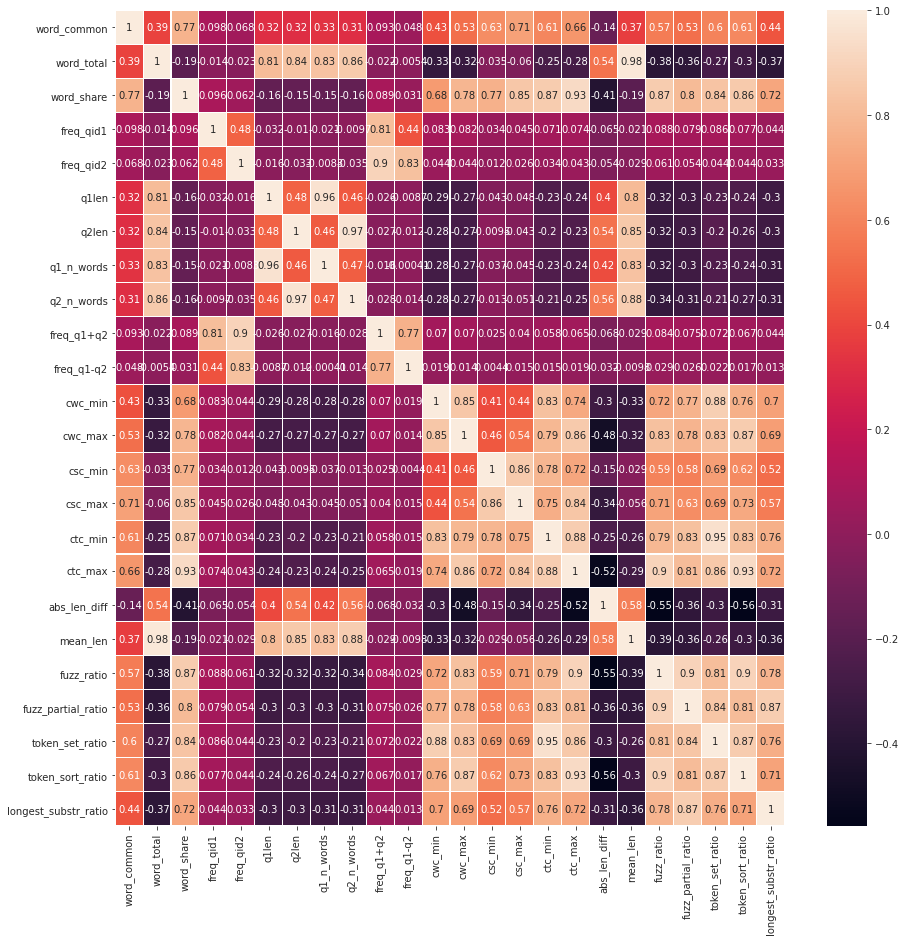

In [0]:
# correlation analysis 

corr_df = df[['word_common', 'word_total', 'word_share', 'freq_qid1',	'freq_qid2', 
            'q1len',	'q2len', 'q1_n_words', 'q2_n_words', 'freq_q1+q2',	'freq_q1-q2',
            'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
            'abs_len_diff', 'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio', 
            'token_set_ratio','token_sort_ratio', 'longest_substr_ratio']]

plt.figure(figsize = (15,15))
corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix, linewidth = 0.01, annot = True)
plt.show()

OBSERVATIONS :

(Apart for the ones we saw in the previous correlation heatmap)

1. 'word_share' feature shows high correlation with all the new features we extracted above - 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio','token_sort_ratio', 'longest_substr_ratio'.

2. Length of string and number of words features we created previously is highly correlated with the mean length of question, which is quiet obvious!

3. All fuzz features (i.e. 'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio','token_sort_ratio') show good correlation amongst themselves and also with the longest substring feature. 

4. Common words count (cwc_min & cwc_max) show high correlation with Common token count (ctc_min & ctc_max) and all the fuzz features including longest_substr_ratio.

5. Common stopwords count (csc_min & csc_max) is moderately correlated with the above features with an exception that csc_max shows high correlation with ctc_max.

6. Common token count (ctc_min and ctc_max) show good correlation with the fuzz features and longest_substr_ratio. ctc_min is strongly correlated with token_set ratio, while ctc_max is strongly correlated ith token_sort_ratio.

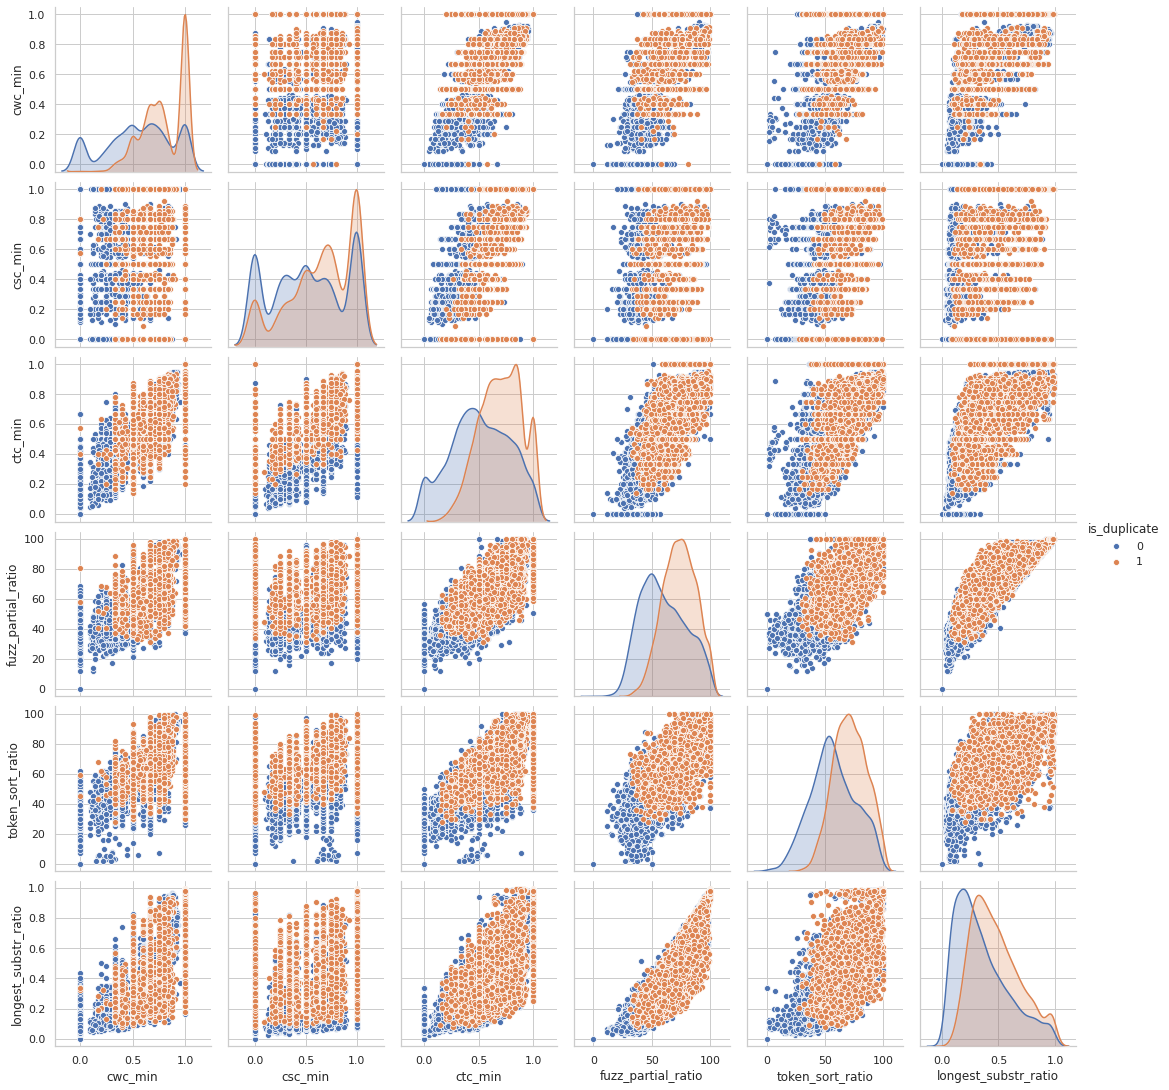

In [0]:
# Bivariate exploratory data analysis with pair plot

df_pair1 = df.sample(n = 10000, random_state = 42) # randomly sample 10k points
df_pair1 = df_pair1[['cwc_min', 'csc_min', 'ctc_min', 'fuzz_partial_ratio', 
                     'token_sort_ratio', 'longest_substr_ratio', 'is_duplicate']]

plt.close()
sns.set(style = 'whitegrid')
sns.pairplot(df_pair1, hue = "is_duplicate")

OBSERVATIONS:

The pair plots show overlap good amount of overalp among the feature take2 at a time. But there are certain regions where one class dominates, while in other region the other class label dominates. 

This shows that these above features that we extracted using NLP feature engineering techniques can prove to be useful in classification task both individually(as seen from diagonal univariate plots) as well as with other features. 

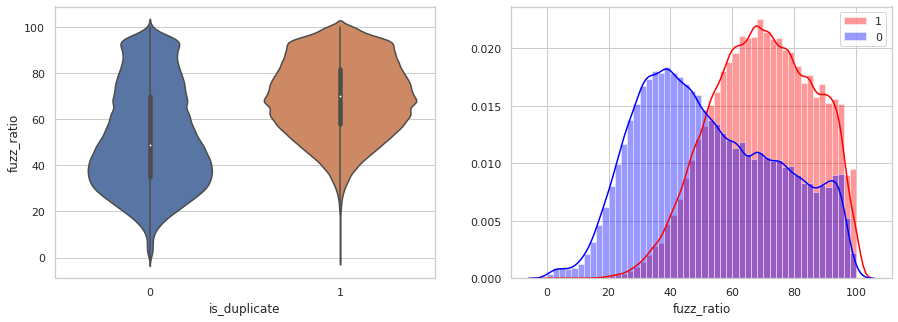

In [0]:
# Univariate analysis - violin plot and PDF of the feature fuzz_ratio

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:], label = "1",  color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:], label = "0",  color = 'blue')
plt.legend()
plt.show()

As seen from above violin plot and PDF for the fuzz_ratio feature, there is some overlap but it not very high. So, this feature can also prove useful in classification task. 

# 7. Data Visualization using T-SNE

### 7.1 Only 15 advanced features  

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimention

from sklearn.preprocessing import MinMaxScaler

# sample random 20k datapoints
df_tsne = df.sample(n = 20000, random_state = 21) 

scaler = MinMaxScaler()
X = scaler.fit_transform(df_tsne[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 
                                  'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 
                                  'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio','token_sort_ratio', 
                                  'longest_substr_ratio']])
y = df_tsne['is_duplicate'].values

In [0]:
%%capture
method = TSNE(n_components = 2, perplexity = 30, learning_rate = 200, 
              n_iter = 5000, verbose = 2, random_state = 42, n_jobs = -1)
X_embedding = method.fit_transform(X)

tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(tsne_data, columns = ("Dimension_1", "Dimension_2", "is_duplicate"))

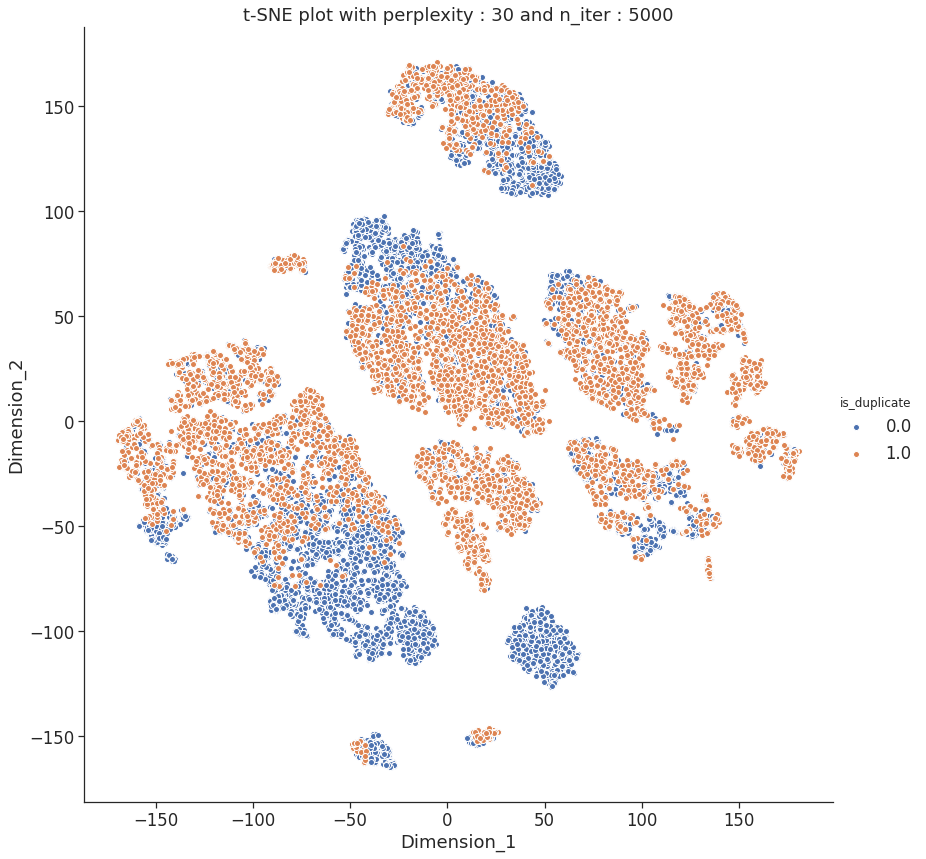

In [0]:
sns.set(style = "ticks", font_scale = 1.5)
sns.FacetGrid(tsne_df, hue = "is_duplicate", height = 12).map(
              plt.scatter, "Dimension_1", "Dimension_2", edgecolor = "w").add_legend()
plt.title("t-SNE plot with perplexity : {} and n_iter : {}".format(30, 5000))
plt.show()

### 7.2 All 26 numerical features together 

In [0]:
# Using TSNE for Dimentionality reduction with all the features togther 

X = scaler.fit_transform(df_tsne[['word_common', 'word_total', 'word_share', 'freq_qid1',	
                                  'freq_qid2','q1len', 'q2len', 'q1_n_words', 'q2_n_words', 
                                  'freq_q1+q2',	'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 
                                  'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 
                                  'abs_len_diff', 'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio', 
                                  'token_set_ratio','token_sort_ratio', 'longest_substr_ratio']])
y = df_tsne['is_duplicate'].values

In [0]:
%%capture
method = TSNE(n_components = 2, perplexity = 30, learning_rate = 200, 
              n_iter = 5000, verbose = 2, random_state = 42, n_jobs = -1)
X_embedding = method.fit_transform(X)

tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(tsne_data, columns = ("Dimension_1", "Dimension_2", "is_duplicate"))

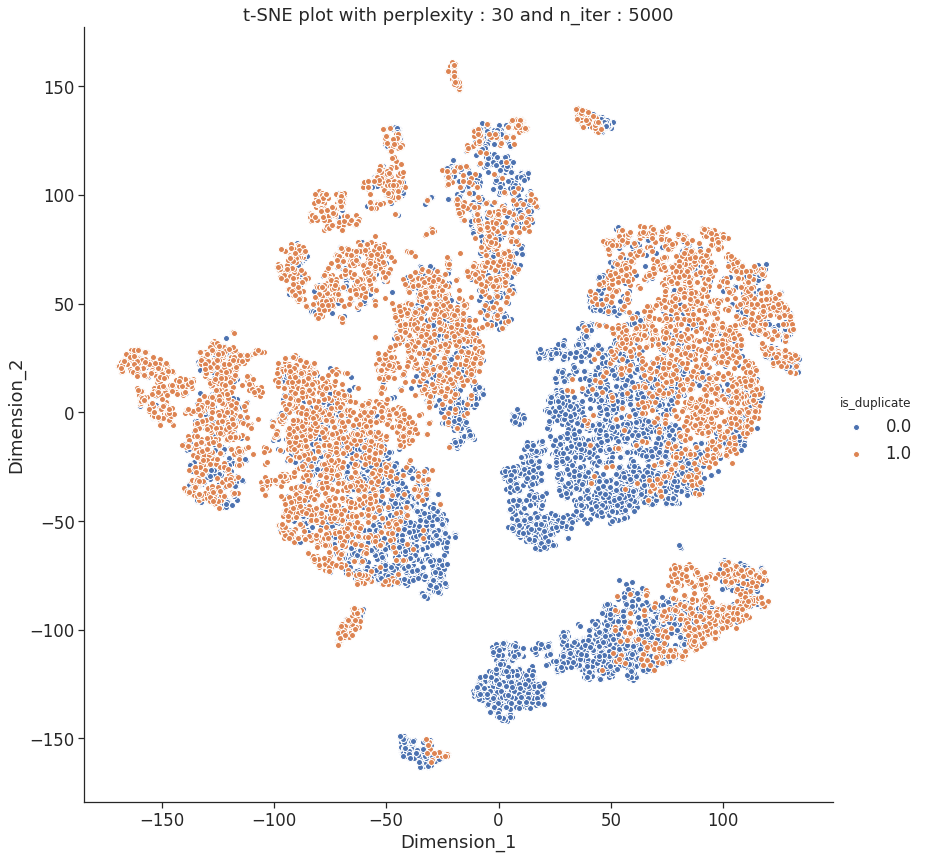

In [0]:
sns.set(style = "ticks", font_scale = 1.5)
sns.FacetGrid(tsne_df, hue = "is_duplicate", height = 12).map(
              plt.scatter, "Dimension_1", "Dimension_2", edgecolor = "w").add_legend()
plt.title("t-SNE plot with perplexity : {} and n_iter : {}".format(30, 5000))
plt.show()

OBSERVATION:

Clearly, when we take all the features together, we get feature seperation. 

# 8. Vectorizing and Normalizing features 

Before we proceed to modelling, we'll remove the redundant columns from the dataframe

In [0]:
# drop redundant features 

df_preprocessed = df.drop(['question1', 'question2', 'clean_question1', 'clean_question2',
                        'id', 'qid1', 'qid2'], axis = 1, inplace = False)

df_preprocessed.columns

Index(['is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_common', 'word_total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'preprocessed_q1', 'preprocessed_q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio',
       'token_sort_ratio', 'longest_substr_ratio'],
      dtype='object')

In [0]:
# seperate the class label column from the rest of dataset which we intend to predict

y = df_preprocessed['is_duplicate'].values
X = df_preprocessed.drop('is_duplicate', axis = 'columns')

X.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio,longest_substr_ratio
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,92,100,100,92,0.982456
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,67,71,86,65,0.580000


In [0]:
# train test splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(283003, 28) (283003,)
(121287, 28) (121287,)


### 8.1 TFIDF weighted Word2Vec encoding


In [0]:
# Vectorizing question 1 and question 2 texts using pretrained GLOVE Model 

'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: 
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

'''

In [0]:
# storing variables into pickle files python:
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file

path = '/content/gdrive/My Drive/Donors_Choose_Dataset/glove_vectors'
with open(path, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# TFIDF weighted Word2Vec function 
# fit on combined question pairs and then vectorize seperately

def tfidf_w2v_vectors(text_fit, text_transform):
    ''' This function returns the vector of length 300 for each text using TFIDF-W2V method'''
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(text_fit)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_text_words = set(tfidf_model.get_feature_names())
    
    tfidf_w2v_text = [] # the tfidf-w2v for each sentence is stored in this list
    for sentence in tqdm(text_transform): # for each review/sentence
        vector = np.zeros(300) # initialize a 0 vector of length 300
        tf_idf_weight = 0 # initializing the number of words with valid vector in the review/sentence
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_text_words):
                vec = model[word] # getting the vector for each word
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # computing tfidf
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_text.append(vector)
    return tfidf_w2v_text

In [0]:
# combine the train question pairs and fit a vectorizer on this

combined_questions = list(X_train['preprocessed_q1']) + list(X_train['preprocessed_q2'])

In [0]:
# computing TFIDF-AVGW2V for preprocessed question1

X_train_q1_tfidfw2v = tfidf_w2v_vectors(combined_questions, X_train['preprocessed_q1'].values)
X_test_q1_tfidfw2v = tfidf_w2v_vectors(combined_questions, X_test['preprocessed_q1'].values)

100%|██████████| 121287/121287 [00:09<00:00, 12956.90it/s]


In [0]:
# computing TFIDF-AVGW2V for preprocessed question2

X_train_q2_tfidfw2v = tfidf_w2v_vectors(combined_questions, X_train['preprocessed_q2'].values)
X_test_q2_tfidfw2v = tfidf_w2v_vectors(combined_questions, X_test['preprocessed_q2'].values)

100%|██████████| 121287/121287 [00:09<00:00, 12640.85it/s]


### 8.2 TFIDF encoding

In [0]:
# TF-IDF vectorization of question1 

vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000)
vectorizer.fit(combined_questions) # fit has to happen only on train data 

X_train_q1_tfidf = vectorizer.transform(X_train['preprocessed_q1'].values)
X_test_q1_tfidf = vectorizer.transform(X_test['preprocessed_q1'].values)

print('After Vectorization')
print(X_train_q1_tfidf.shape, y_train.shape)
print(X_test_q1_tfidf.shape, y_test.shape)

After Vectorization
(283003, 5000) (283003,)
(121287, 5000) (121287,)


In [0]:
# TF-IDF vectorization of question2

vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000)
vectorizer.fit(combined_questions) # fit has to happen only on train data

X_train_q2_tfidf = vectorizer.transform(X_train['preprocessed_q2'].values)
X_test_q2_tfidf = vectorizer.transform(X_test['preprocessed_q2'].values)

print('After Vectorization')
print(X_train_q2_tfidf.shape, y_train.shape)
print(X_test_q2_tfidf.shape, y_test.shape)

After Vectorization
(283003, 5000) (283003,)
(121287, 5000) (121287,)


### 8.3 Stacking features together

In [0]:
# drop question1 and question 2 texts from the dataframe keep only numerical data

X_train_num = X_train.drop(['preprocessed_q1', 'preprocessed_q2'], axis = 1)
X_test_num = X_test.drop(['preprocessed_q1', 'preprocessed_q2'], axis = 1)

#### 8.3.1 Numerical features + TFIDF-W2V vectorized question pairs

In [0]:
# Set 1: stacking all the features together 

X_train_tfidfw2v = np.hstack((X_train_num, X_train_q1_tfidfw2v, X_train_q2_tfidfw2v))
X_test_tfidfw2v = np.hstack((X_test_num, X_test_q1_tfidfw2v, X_test_q2_tfidfw2v))

print(X_train_tfidfw2v.shape, y_train.shape)
print(X_train_tfidfw2v.shape, y_test.shape)

(283003, 626) (283003,)
(283003, 626) (121287,)


In [0]:
# normalizing the features using standard scaler 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_tfidfw2v)

X_train_tfidfw2v_norm = scaler.transform(X_train_tfidfw2v)
X_test_tfidfw2v_norm = scaler.transform(X_test_tfidfw2v)

#### 8.3.2 Numerical features + TFIDF vectorized question pairs

In [0]:
# normalizing the numerical features using standard scaler 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num_norm = scaler.transform(X_train_num)
X_test_num_norm = scaler.transform(X_test_num)

In [0]:
# Set 2: stacking all the features together

from scipy.sparse import hstack

X_train_tfidf = hstack((X_train_num_norm, X_train_q1_tfidf, X_train_q2_tfidf))
X_test_tfidf = hstack((X_test_num_norm, X_test_q1_tfidf, X_test_q2_tfidf))

print(X_train_tfidf.shape, y_train.shape)
print(X_train_tfidf.shape, y_test.shape)

(283003, 10026) (283003,)
(283003, 10026) (121287,)


# 9. Building ML Classification Models

### Random Model 

In [0]:
# This function plots the confusion matrices given the actual and predicted class labels

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = (((C.T)/(C.sum(axis=1))).T)
    
    B = (C/C.sum(axis = 0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing Confusion matrix C using seaborn heatmap
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap = "YlGnBu", fmt=".3f", linewidths=.25, xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Confusion Matrix")
    
    # representing Precision Matrix B using seaborn heatmap
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap = "YlGnBu", fmt=".3f", linewidths=.25, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Precision Matrix")
    
    plt.subplot(1, 3, 3)
    # representing Recall Matrix A using seaborn heatmap
    sns.heatmap(A, annot=True, cmap = "YlGnBu", fmt=".3f", linewidths=.25, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Recall Matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8846457858292834


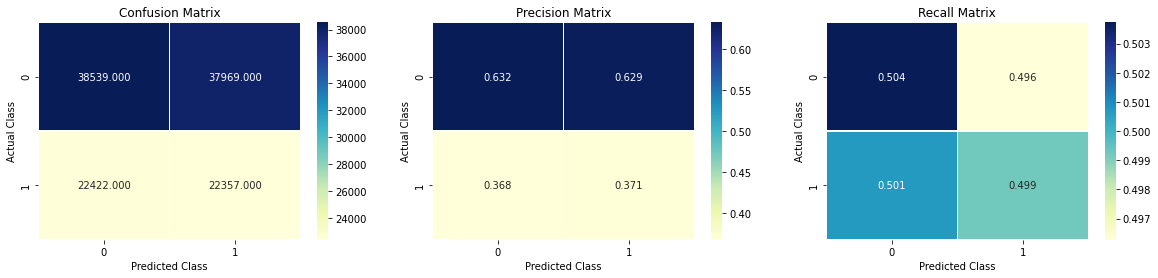

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# we create a output array that has exactly same size as the CV data

predicted_y = np.zeros((test_len, 2))

for i in range(test_len):
    rand_probs = np.random.rand(1, 2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs))))
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y = np.argmax(predicted_y, axis = 1)
plot_confusion_matrix(y_test, predicted_y)

## Model 1A: Logistic Regression (with TFIDF-W2V vectorized text)

In [0]:
# Logistic Regression with hyperparameter tuning

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss ='log', random_state = 21)
    clf.fit(X_train_tfidfw2v_norm, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(X_train_tfidfw2v_norm, y_train)
    y_pred = sig_clf.predict_proba(X_test_tfidfw2v_norm)
    loss = log_loss(y_test, y_pred)
    log_error_array.append(loss)
    print('For value of alpha = ', i, "the log-loss is: ", loss)

For value of alpha =  1e-05 the log-loss is:  0.41148785582056624
For value of alpha =  0.0001 the log-loss is:  0.3995714738983938
For value of alpha =  0.001 the log-loss is:  0.3971014172367875
For value of alpha =  0.01 the log-loss is:  0.408838045192137
For value of alpha =  0.1 the log-loss is:  0.44346422830416443
For value of alpha =  1 the log-loss is:  0.48927105107401453
For value of alpha =  10 the log-loss is:  0.5219945380047271


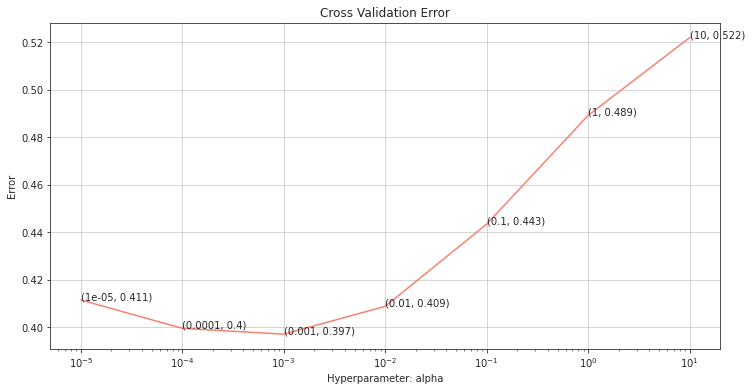

In [0]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(alpha, log_error_array, c ='salmon')
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))

plt.xscale('log')
plt.title("Cross Validation Error")
plt.xlabel("Hyperparameter: alpha")
plt.ylabel("Error")
plt.grid()
plt.show()

Best alpha =  0.001 Train log-loss:  0.39645860086458573
Best alpha =  0.001 Test log-loss:  0.3971014172367875
Total number of data points : 121287


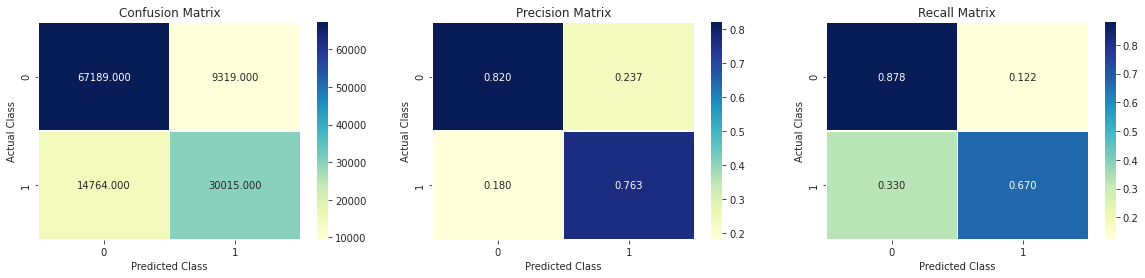

In [0]:
# make prediction using the best value of hyperparameter found above

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss = 'log', random_state = 21)
clf.fit(X_train_tfidfw2v_norm, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(X_train_tfidfw2v_norm, y_train)

y_pred_train = sig_clf.predict_proba(X_train_tfidfw2v_norm)
train_loss = log_loss(y_train, y_pred_train)
print('Best alpha = ', alpha[best_alpha], "Train log-loss: ", train_loss)

y_pred_test = sig_clf.predict_proba(X_test_tfidfw2v_norm) # predict_proba returns probability ordered by class labels
test_loss = log_loss(y_test, y_pred_test)
print('Best alpha = ', alpha[best_alpha], "Test log-loss: ", test_loss)

y_predicted = np.argmax(y_pred_test, axis = 1) # returns the index of whichever probability is max
print("Total number of data points :", len(y_predicted))
plot_confusion_matrix(y_test, y_predicted)

## Model 1B: Logistic Regression (with TFIDF vectorized text)

In [0]:
# Logistic Regression with hyperparameter tuning

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss ='log', random_state = 42)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    y_pred = sig_clf.predict_proba(X_test_tfidf)
    loss = log_loss(y_test, y_pred, labels = clf.classes_)
    log_error_array.append(loss)
    print('For value of alpha = ', i, "the log-loss is: ", loss)

For value of alpha =  1e-05 the log-loss is:  0.3658118115963924
For value of alpha =  0.0001 the log-loss is:  0.3766235374086008
For value of alpha =  0.001 the log-loss is:  0.3947481536721808
For value of alpha =  0.01 the log-loss is:  0.4192268426402491
For value of alpha =  0.1 the log-loss is:  0.45853523100679444
For value of alpha =  1 the log-loss is:  0.5089866108157078
For value of alpha =  10 the log-loss is:  0.5354573526650422


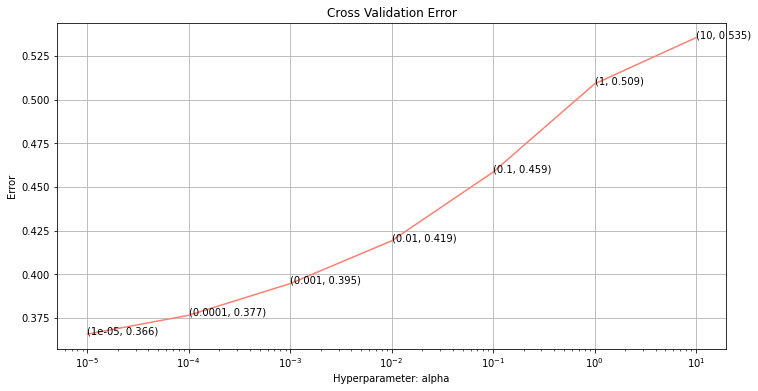

In [0]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(alpha, log_error_array, c ='salmon')
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))

plt.xscale('log')
plt.title("Cross Validation Error")
plt.xlabel("Hyperparameter: alpha")
plt.ylabel("Error")
plt.grid()
plt.show()

Best alpha =  1e-05 Train log-loss:  0.35422260463915234
Best alpha =  1e-05 Test log-loss:  0.3658118115963924
Total number of data points : 121287


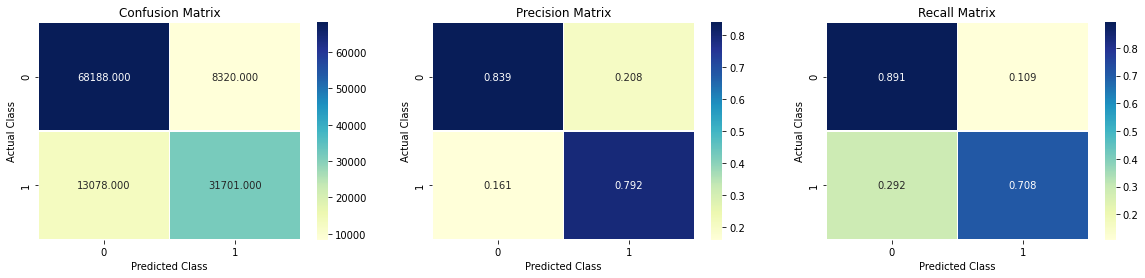

In [0]:
# make predictions with best hyperparameter 

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss = 'log', random_state = 42)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

y_pred_train = sig_clf.predict_proba(X_train_tfidf)
train_loss = log_loss(y_train, y_pred_train, labels = clf.classes_)
print('Best alpha = ', alpha[best_alpha], "Train log-loss: ", train_loss)

y_pred_test = sig_clf.predict_proba(X_test_tfidf)
test_loss = log_loss(y_test, y_pred_test, labels = clf.classes_)
print('Best alpha = ', alpha[best_alpha], "Test log-loss: ", test_loss)

y_predicted = np.argmax(y_pred_test, axis = 1)
print("Total number of data points :", len(y_predicted))
plot_confusion_matrix(y_test, y_predicted)

## Model 2A: Linear SVM (with TFIDF-W2V vectorized text)

In [0]:
# Linear SVM with hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l1', loss = 'hinge', random_state = 101)
    clf.fit(X_train_tfidfw2v_norm, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(X_train_tfidfw2v_norm, y_train)
    y_pred = sig_clf.predict_proba(X_test_tfidfw2v_norm)
    loss = log_loss(y_test, y_pred, labels = clf.classes_)
    log_error_array.append(loss)
    print('For value of alpha = ', i, "the log-loss is: ", loss)

For value of alpha =  1e-05 the log-loss is:  0.41493413425246434
For value of alpha =  0.0001 the log-loss is:  0.40171143446641616
For value of alpha =  0.001 the log-loss is:  0.45008634655377383
For value of alpha =  0.01 the log-loss is:  0.4391391960233214
For value of alpha =  0.1 the log-loss is:  0.5459658156091868
For value of alpha =  1 the log-loss is:  0.6585278256322701
For value of alpha =  10 the log-loss is:  0.6585278256322701


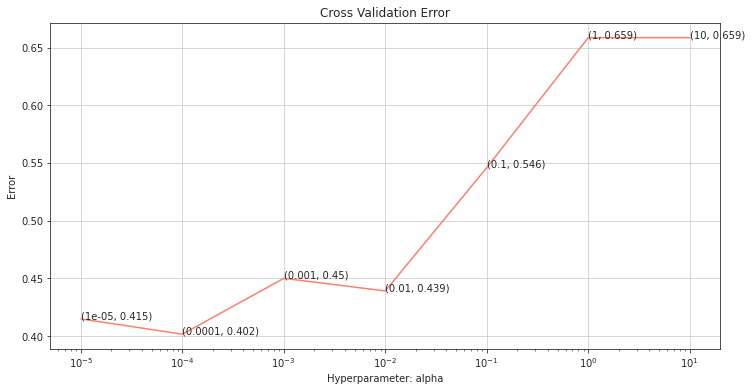

In [0]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(alpha, log_error_array, c ='salmon')
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))

plt.xscale('log')
plt.title("Cross Validation Error")
plt.xlabel("Hyperparameter: alpha")
plt.ylabel("Error")
plt.grid()
plt.show()

Best alpha =  0.0001 Train log-loss:  0.4009707674850347
Best alpha =  0.0001 Test log-loss:  0.40171143446641616
Total number of data points : 121287


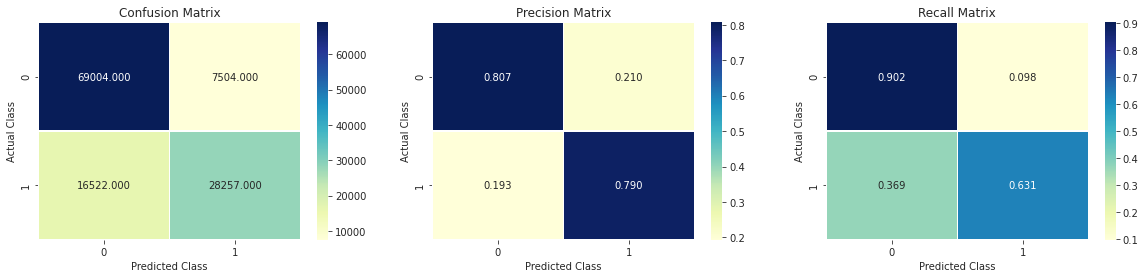

In [0]:
# make predictions using the best hyperparameter value

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l1', loss = 'hinge', random_state = 101)
clf.fit(X_train_tfidfw2v_norm, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidfw2v_norm, y_train)

y_pred_train = sig_clf.predict_proba(X_train_tfidfw2v_norm)
train_loss = log_loss(y_train, y_pred_train, labels = clf.classes_)
print('Best alpha = ', alpha[best_alpha], "Train log-loss: ", train_loss)

y_pred_test = sig_clf.predict_proba(X_test_tfidfw2v_norm) # predict_proba returns probability ordered by class labels
test_loss = log_loss(y_test, y_pred_test, labels = clf.classes_)
print('Best alpha = ', alpha[best_alpha], "Test log-loss: ", test_loss)

y_predicted = np.argmax(y_pred_test, axis = 1) # returns the index of whichever probability is max
print("Total number of data points :", len(y_predicted))
plot_confusion_matrix(y_test, y_predicted)

## Model 2B: Linear SVM (with TFIDF vectorized text)

In [0]:
# Linear SVM with hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l1', loss = 'hinge', random_state = 101)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    y_pred = sig_clf.predict_proba(X_test_tfidf)
    loss = log_loss(y_test, y_pred, labels = clf.classes_)
    log_error_array.append(loss)
    print('For value of alpha = ', i, "the log-loss is: ", loss)

For value of alpha =  1e-05 the log-loss is:  0.3777263584135386
For value of alpha =  0.0001 the log-loss is:  0.4006619541930958
For value of alpha =  0.001 the log-loss is:  0.4207370490107046
For value of alpha =  0.01 the log-loss is:  0.4265495749137563
For value of alpha =  0.1 the log-loss is:  0.5345474172902075
For value of alpha =  1 the log-loss is:  0.6585278256322702
For value of alpha =  10 the log-loss is:  0.6585278256322702


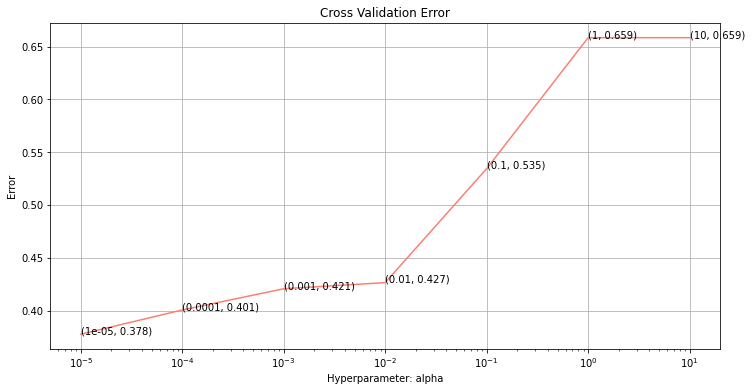

In [0]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(alpha, log_error_array, c ='salmon')
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))

plt.xscale('log')
plt.title("Cross Validation Error")
plt.xlabel("Hyperparameter: alpha")
plt.ylabel("Error")
plt.grid()
plt.show()

Best alpha =  1e-05 Train log-loss:  0.3670030960790454
Best alpha =  1e-05 Test log-loss:  0.3777263584135386
Total number of data points : 121287


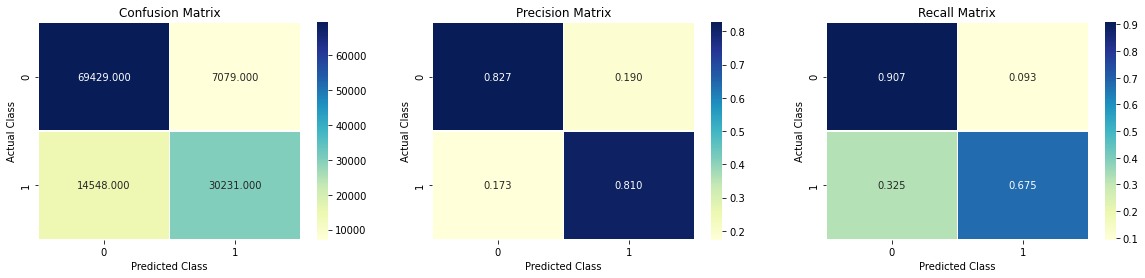

In [0]:
# make predictions using the best hyperparameter

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l1', loss = 'hinge', random_state = 101)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

y_pred_train = sig_clf.predict_proba(X_train_tfidf)
train_loss = log_loss(y_train, y_pred_train, labels = clf.classes_)
print('Best alpha = ', alpha[best_alpha], "Train log-loss: ", train_loss)

y_pred_test = sig_clf.predict_proba(X_test_tfidf)
test_loss = log_loss(y_test, y_pred_test, labels = clf.classes_)
print('Best alpha = ', alpha[best_alpha], "Test log-loss: ", test_loss)

y_predicted = np.argmax(y_pred_test, axis = 1)
print("Total number of data points :", len(y_predicted))
plot_confusion_matrix(y_test, y_predicted)

## Model 3: XGBoost (with TFIDF-W2V vectorized text)

In [0]:
# XGBoost with hyperparameter tuning

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric='logloss', n_jobs=-1)

params = {"learning_rate":stats.uniform(0.01, 0.6),
          "max_depth": [3, 5, 7, 9],
          "n_estimators" : stats.randint(10, 1000),
          "min_child_weight" : [1, 3, 5, 7],
          "gamma": [0, 0.25, 0.5, 1.0],
          "subsample": stats.uniform(0.3, 0.9),
          "colsample_bytree": stats.uniform(0.5, 0.9)
         }

clf = RandomizedSearchCV(clf_xgb, param_distributions = params, n_iter = 10,
                         scoring = 'neg_log_loss', n_jobs = -1, cv = 3)

clf.fit(X_train_tfidfw2v, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb8128a7710>,
                                        'max_dept

In [0]:
# best score and corresponding best set of hyperparameters

print("Score : ", clf.best_score_)
print("Best Params", clf.best_params_)

Score :  -0.32598027446876293
Best Params {'colsample_bytree': 0.9196437594750173, 'gamma': 0.5, 'learning_rate': 0.5131066646779973, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 409, 'subsample': 0.7591735173200865}


Train log-loss:  0.21579866573898787
Test log-loss:  0.31051785980449825
Total number of data points : 121287


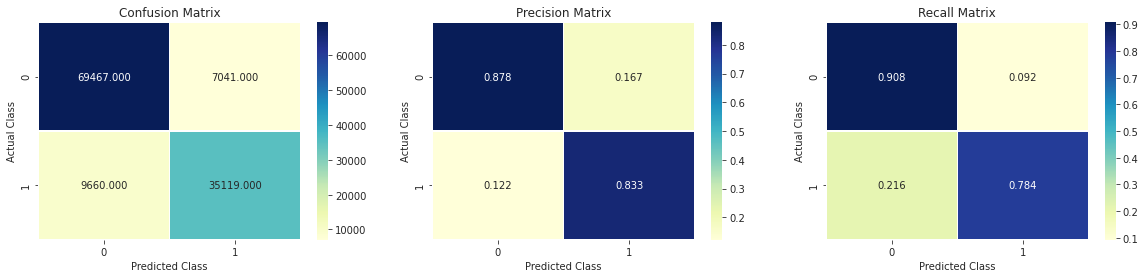

In [0]:
# make predictions using the best set of hyperparameters

import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV

xgb_best_clf = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', n_jobs = -1, 
                             colsample_bytree = 0.92, gamma = 0.5, learning_rate = 0.513, 
                             max_depth = 9, min_child_weight = 7, n_estimators= 409, subsample = 0.76)

xgb_best_clf.fit(X_train_tfidfw2v, y_train)
sig_clf = CalibratedClassifierCV(xgb_best_clf, method = "sigmoid")
sig_clf.fit(X_train_tfidfw2v, y_train)

y_pred_train = sig_clf.predict_proba(X_train_tfidfw2v)
train_loss = log_loss(y_train, y_pred_train, labels = xgb_best_clf.classes_)
print("Train log-loss: ", train_loss)

y_pred_test = sig_clf.predict_proba(X_test_tfidfw2v)
test_loss = log_loss(y_test, y_pred_test, labels = xgb_best_clf.classes_)
print("Test log-loss: ", test_loss)

y_predicted = np.argmax(y_pred_test, axis = 1)
print("Total number of data points :", len(y_predicted))
plot_confusion_matrix(y_test, y_predicted)

# 10. Consolidated Scores & Summary

In [1]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ("Model no.", "Model", "Vectorizer", "Hyperparameter tuning" , "Test loss", "Train loss")
table.add_row(["1A.\n", "Logistic Regression", "TFIDF-W2v", "YES", 0.397, 0.396])
table.add_row(["1B.\n", "Logistic Regression", "TFIDF", "YES", 0.366, 0.354])
table.add_row(["2A.\n", "Linear SVM", "TFIDF-W2v", "YES", 0.402, 0.401])
table.add_row(["2B.\n", "Linear SVM", "TFIDF", "YES", 0.378, 0.367])
table.add_row(["3.", "XGBoost", "TFIDF-W2V", "YES", 0.310, 0.216])

print(table)

+-----------+---------------------+------------+-----------------------+-----------+------------+
| Model no. |        Model        | Vectorizer | Hyperparameter tuning | Test loss | Train loss |
+-----------+---------------------+------------+-----------------------+-----------+------------+
|    1A.    | Logistic Regression | TFIDF-W2v  |          YES          |   0.397   |   0.396    |
|           |                     |            |                       |           |            |
|    1B.    | Logistic Regression |   TFIDF    |          YES          |   0.366   |   0.354    |
|           |                     |            |                       |           |            |
|    2A.    |      Linear SVM     | TFIDF-W2v  |          YES          |   0.402   |   0.401    |
|           |                     |            |                       |           |            |
|    2B.    |      Linear SVM     |   TFIDF    |          YES          |   0.378   |   0.367    |
|           |       

Tree-based ensemble model XGBoost gave better performance as compared to the Linear models models like Logistic regression and Linear SVM.

### SUMMARY

1. The original dataset comprises of 404290 rows and 6 columns. We checked for the null values and found couple of null entries in the questions which were replaced with empty string.


2. Class label distribution:

    * is_duplicate = 0  ->  255027 datapoints (~ 63%)

    * is_duplicate = 1  ->  149263 datapoints (~ 37%)


3. Wordcloud observation:
    * Most common words in duplicate question pairs  ->  "difference", "best way", "Donald Trump", "Hillary Clinton" etc.

    * Most common words in non_duplicate question pairs  ->  "India", "will", "difference", "not", "like", "best", "best way" etc. 


4. Then we found the total number of unique question in the entire dataframe and plotted a histogram of their frequencies. Most questions occur only once or twice, while there are relatively very few questions that are asked more than 10 times. The highest number of times any question is asked is 10. 


5. Next we extracted some basic features like frequency of the questions, string length of the questions, number of words in the questions and the features that are combination of these. We also created a new feature word share which is equal to number of common words divided by total unique words. 


6. Then we performed the correlation analysis of the newly extracted features above using seaborn heatmap and found that some pairs of feature are highly correlated.


7. Furthur we performed Univariate analysis on some of the extracted features and concluded that "word_share" feature does moderately good job in seperating the class labels while "word_common" feature is terrible due to high overlap. This also suggests that having high number of words common among the question pairs doesn't mean that they are likely to be duplicates. 


8. Before proceeding to advanced feature engineering, we investigated some random question texts to come-up with a text-preprocessing pipe-line. The text preprocessing pipe-line includes the usual steps - Expanding contractions, Removing html tags, Removing special characters like '%','&', '@' etc., Removing Stopwords and Performing stemming. 


9. In the Advanced feature engineering sections we further constructed 15 new features. This includes features like the ratio of common token counts divided by the min and max token lengths among question 1 and question 2. Similary, we did same for stop word counts and meaningful word (i.e.token words - stop words) counts. We also added some fuzzy features like fuzz_ratio, fuzz_parial ratio, etc. and some other features that check if first word of q1 and q2 is same, last word is same, mean length and absolute length difference. 
Reference -> https://github.com/seatgeek/fuzzywuzzy
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


10. Just like the previous sections, the feature extraction is followed by the correlation analysis, bi-variate analysis using pair plot and univariate analysis. This is followed by t-SNE wherein we visualize the 15 and 26 dimension data respectively by embedding it in 2 dimension such that the neigbourhood is preserved. 


11. Before proceeding to building a classification model, we vectorize our text data of question 1 and question 2 using TF-IDF weighted Word2Vec vectorizer(question text -> 300 features each) as well as only TF-IDF vectorized (question vector -> 5000 features each). Note that here the vocabulary for the text vectorization should be built on the combined question1 and question2 texts.


12. Now we have 3 sets of features - 
    * Basic features (word_common, word_share, question frequencies etc.)
    * Advanced features (cwc_min, csc_max, fuzz_ratio, etc.)
    * TFIDF-W2V / TFIDF Vectorized text features. 

  We stack all the features together and proceed to train our Machine Learning models. 


13. The business metric we are using for checking the model performance is log-loss. 

  The models we train are - 
    * Logistic regression (with TFIDF-W2V vectorized text data).
    * Logistic regression (with TFIDF vectorized text data).
    * Linear SVM (with TFIDF-W2V vectorized text data).
    * Linear SVM (with TFIDF vectorized text data).
    * XGBoost (with TFIDF vectorized text data).

  All the above models we build by using the best set of hyperparameters found by Grid Search and Randomized Search.


14. In order to compute the log-loss metric, the predicted output should actually be probability scores instead of class labels. So after featching the probability scores from the above classification models, we perform an additional step of calibration in order to obtain the correct probability scores. 


15. Finally the class-labels are predicted from the corrected probability scores and the results of each model are displayed in form of Confusion matrix, Precision matrix and Recall matrix. The consolidated results from all the models are already summerized above in the Conclusion section. 


16. It is observed that tree-based ensemble model XGBoost tends to perform better as compared to the Linear models models like Logistic regression and Linear SVM. In case of linear models, model with TF-IDF vectorized text features outformes the model with TFIDF-W2V vectorized text features. 